Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8112 - loss: 0.0209 - val_accuracy: 0.8160 - val_loss: 0.0053
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8158 - loss: 0.0048 - val_accuracy: 0.8161 - val_loss: 0.0039
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8153 - loss: 0.0038 - val_accuracy: 0.8161 - val_loss: 0.0033
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8149 - loss: 0.0033 - val_accuracy: 0.8161 - val_loss: 0.0030
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8152 - loss: 0.0030 - val_accuracy: 0.8161 - val_loss: 0.0027
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8156 - loss: 0.0027 - val_accuracy: 0.8161 - val_loss: 0.0026
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8154 - loss: 0.0025 - val_accuracy: 0.8161 - val_loss: 0.0026
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8151 - loss: 0.0023 - val_accuracy: 0

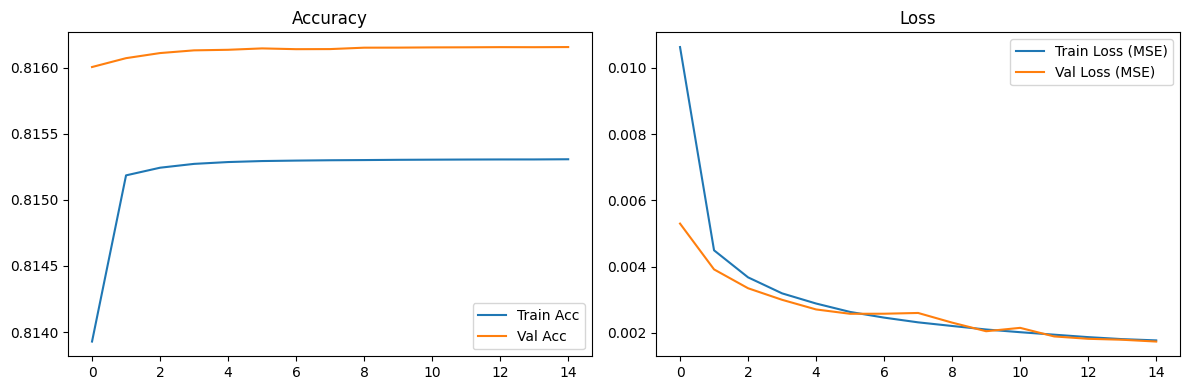

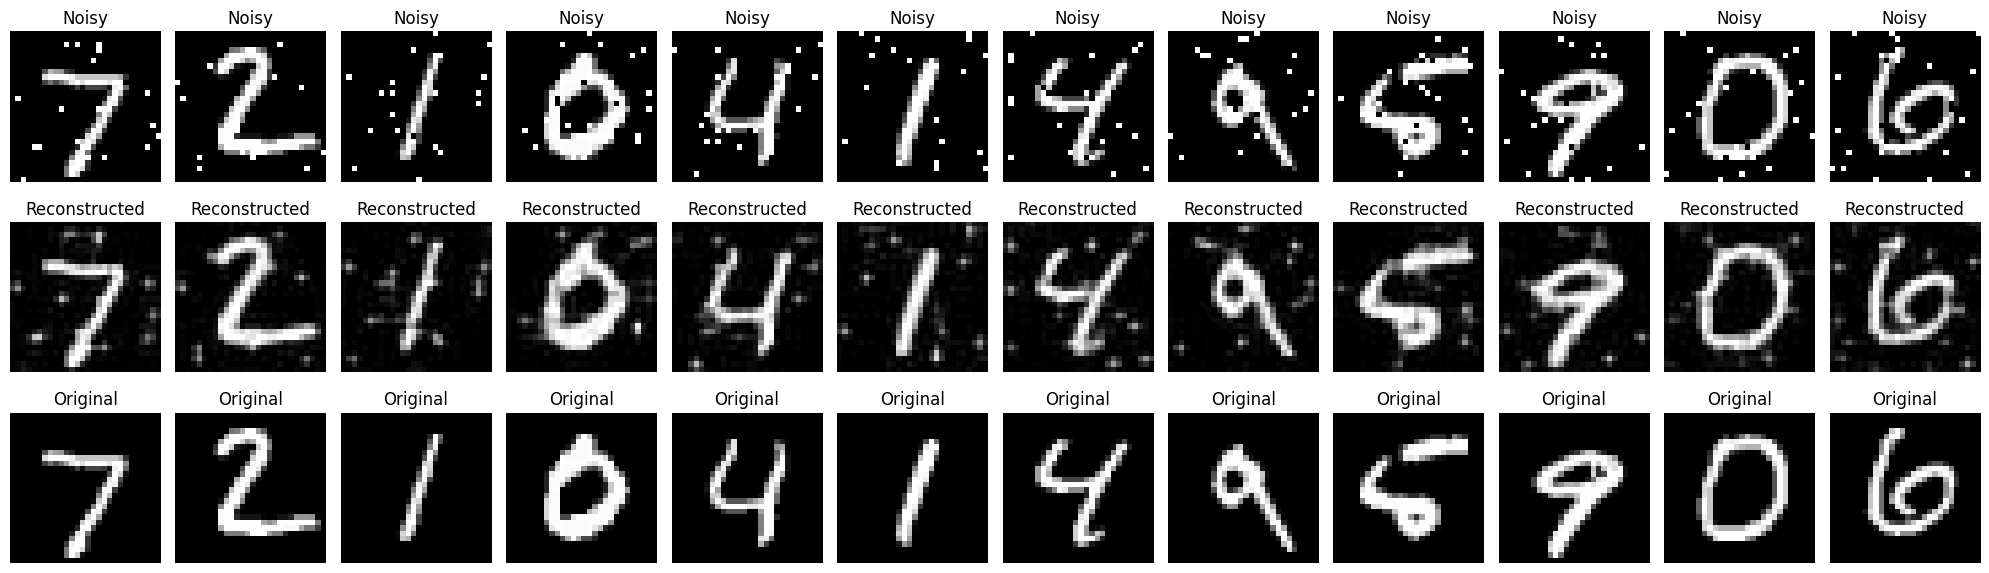

In [2]:
from keras import layers, models, datasets
import numpy as np
import matplotlib.pyplot as plt
import keras

# ---------------------------
# Conv2D 헬퍼
# ---------------------------
def Conv2D(filters, kernel_size, padding='same', activation='relu'):
    """일관된 Conv2D 생성 헬퍼"""
    return layers.Conv2D(filters, kernel_size, padding=padding, activation=activation)

# ---------------------------
# AutoEncoder 정의
# ---------------------------
class AE(models.Model):
    """
    입력: (28, 28, 1)  (channels_last)
    Encoder: 28 -> 14 -> 7
    Decoder: 7  -> 14 -> 28
    Conv2D + UpSampling2D만 사용
    """
    def __init__(self, org_shape=(28, 28, 1)):
        inp = layers.Input(shape=org_shape)

        # ----- Encoder -----
        x = Conv2D(32, (3, 3))(inp)                         # 28x28
        x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 14x14
        x = Conv2D(64, (3, 3))(x)                           # 14x14
        x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 7x7
        z = Conv2D(128, (3, 3), padding='same')(x)          # 7x7(bottleneck)

        # ----- Decoder -----
        y = Conv2D(64, (3, 3), activation='relu', padding='same')(z)
        y = layers.UpSampling2D((2, 2))(y)                  # 7->14
        y = Conv2D(32, (3, 3), activation='relu', padding='same')(y)
        y = layers.UpSampling2D((2, 2))(y)                  # 14->28

        out = Conv2D(1, (3, 3), activation='linear', padding='same')(y)
        super().__init__(inp, out)
        self.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# ---------------------------
# 데이터 로드 + 테스트 노이즈 생성
# ---------------------------
class DATA:
    """
    - 학습: 기존 이미지
    - 테스트: x_test_noisy를 생성 (salt & pepper)
    """
    def __init__(self, sp_amount=0.05, seed=42):
        rng = np.random.default_rng(seed)

        (x_train, _), (x_test, _) = datasets.mnist.load_data()
        x_train = (x_train.astype('float32') / 255.0).reshape((-1, 28, 28, 1))
        x_test  = (x_test.astype('float32')  / 255.0).reshape((-1, 28, 28, 1))

        def add_salt_pepper(img):
            """한 장의 (28,28,1) 이미지에 S&P 노이즈를 추가"""
            x = img.copy()
            h, w, c = x.shape
            n_pix = h * w * c
            n_sp = int(n_pix * sp_amount)
            flat = x.reshape(-1)
            # salt(1.0)
            idx = rng.choice(n_pix, size=n_sp // 2, replace=False)
            flat[idx] = 1.0
            # pepper(0.0)
            idx = rng.choice(n_pix, size=n_sp - n_sp // 2, replace=False)
            flat[idx] = 0.0
            return flat.reshape(h, w, c)

        x_test_noisy = np.array([add_salt_pepper(img) for img in x_test])

        self.input_shape = (28, 28, 1)
        self.x_train, self.x_test = x_train, x_test
        self.x_test_noisy = x_test_noisy

# ---------------------------
# 시각화 / 학습 곡선
# ---------------------------
def show_ae(model, data, n=10):
    decoded = model.predict(data.x_test_noisy[:n], verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # noisy
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data.x_test_noisy[i, ..., 0], cmap='gray', vmin=0, vmax=1)
        ax.set_title("Noisy"); ax.axis('off')

        # reconstructed
        ax = plt.subplot(3, n, i + 1 + n)
        # linear 출력이라 범위를 넘어갈 수 있어 clip
        rec = np.clip(decoded[i, ..., 0], 0.0, 1.0)
        plt.imshow(rec, cmap='gray', vmin=0, vmax=1)
        ax.set_title("Reconstructed"); ax.axis('off')

        # original
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(data.x_test[i, ..., 0], cmap='gray', vmin=0, vmax=1)
        ax.set_title("Original"); ax.axis('off')
    plt.tight_layout(); plt.show()

def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss (MSE)')
    plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
    plt.title('Loss'); plt.legend()

    plt.tight_layout(); plt.show()

# ---------------------------
# main: 학습 + 검증 + 테스트 시각화
# ---------------------------
def main(epochs=15, batch_size=128, sp_amount_test=0.05):
    data = DATA(sp_amount=sp_amount_test)
    ae = AE(data.input_shape)

    # 학습: clean → clean
    history = ae.fit(
        x=data.x_train, y=data.x_train,
        epochs=epochs, batch_size=batch_size,
        shuffle=True, validation_split=0.2, verbose=1
    )

    # 기존 검증 플롯(accuracy/loss)
    plot_history(history)

    # 테스트: noisy 입력 → 복원 시각화
    show_ae(ae, data, n=12)

if __name__ == "__main__":
    main()
